In [32]:
#İlk çalıştırmada alınan hatalar ikinci seferde düzelmektedir. Lütfen iki sefer çalıştırınız.
import re
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, SpatialDropout1D

from keras.utils.np_utils import to_categorical

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'keras.utils.np_utils'

In [33]:
Dataset = pd.read_csv('Sentiment.csv')

In [34]:
Dataset.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [35]:
m, n = Dataset.shape

print(f'Number of rows in dataset : {m}')
print(f'Number of columns in dataset : {n}')

Number of rows in dataset : 13871
Number of columns in dataset : 21


In [36]:
Dataset.columns

Index(['id', 'candidate', 'candidate_confidence', 'relevant_yn',
       'relevant_yn_confidence', 'sentiment', 'sentiment_confidence',
       'subject_matter', 'subject_matter_confidence', 'candidate_gold', 'name',
       'relevant_yn_gold', 'retweet_count', 'sentiment_gold',
       'subject_matter_gold', 'text', 'tweet_coord', 'tweet_created',
       'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

In [37]:
# Gerekli sütunlar seçildi.

Dataset = Dataset[['text', 'sentiment']]

In [38]:
Dataset.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


In [39]:
Dataset['text']

0        RT @NancyLeeGrahn: How did everyone feel about...
1        RT @ScottWalker: Didn't catch the full #GOPdeb...
2        RT @TJMShow: No mention of Tamir Rice and the ...
3        RT @RobGeorge: That Carly Fiorina is trending ...
4        RT @DanScavino: #GOPDebate w/ @realDonaldTrump...
                               ...                        
13866    RT @cappy_yarbrough: Love to see men who will ...
13867    RT @georgehenryw: Who thought Huckabee exceede...
13868    RT @Lrihendry: #TedCruz As President, I will a...
13869    RT @JRehling: #GOPDebate Donald Trump says tha...
13870    RT @Lrihendry: #TedCruz headed into the Presid...
Name: text, Length: 13871, dtype: object

In [40]:
Dataset['text'] = Dataset['text'].map(lambda x: x.lower())
Dataset['text'] = Dataset['text'].map(lambda x: re.sub('[^a-z0-9\s]','', x))

for i in range(Dataset.shape[0]):
    Dataset['text'][i] = Dataset['text'][i].replace('rt', '')

In [41]:
Dataset['text']

0         nancyleegrahn how did everyone feel about the...
1         scottwalker didnt catch the full gopdebate la...
2         tjmshow no mention of tamir rice and the gopd...
3         robgeorge that carly fiorina is trending  hou...
4         danscavino gopdebate w realdonaldtrump delive...
                               ...                        
13866     cappyyarbrough love to see men who will never...
13867     georgehenryw who thought huckabee exceeded th...
13868     lrihendry tedcruz as president i will always ...
13869     jrehling gopdebate donald trump says that he ...
13870     lrihendry tedcruz headed into the presidentia...
Name: text, Length: 13871, dtype: object

In [42]:
# Duygu sütununda benzersiz değerlerin sayısı gösterildi.

Uniq_vals = Dataset['sentiment'].value_counts()
Uniq_vals

sentiment
Negative    8493
Neutral     3142
Positive    2236
Name: count, dtype: int64

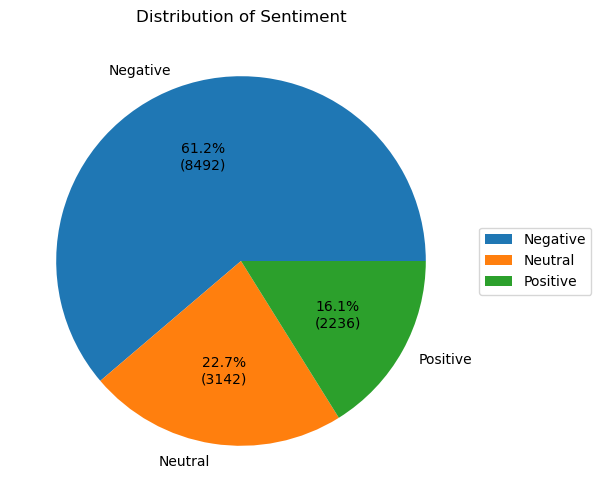

In [43]:
#Duyguların yüzdelik değerleri bulunarak görselleştirme işlemi yapıldı.
LABELS = ['Negative', 'Neutral', 'Positive']

def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

fig, ax = plt.subplots(figsize =(8, 6))
ax.pie(Uniq_vals, 
       labels=LABELS, 
       autopct=lambda pct: func(pct, Uniq_vals))

ax.legend(loc ="center left", bbox_to_anchor =(1, 0, 0.5, 1))
ax.set_title('Distribution of Sentiment')
plt.show()

In [44]:
max_features = 2000   

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(Dataset['text'].values)
X = tokenizer.texts_to_sequences(Dataset['text'].values)
X = pad_sequences(X)

In [45]:
X

array([[   0,    0,    0, ...,   51, 1019,    1],
       [   0,    0,    0, ..., 1556, 1328,  831],
       [   0,    0,    0, ...,   10,  684,  511],
       ...,
       [   0,    0,    0, ...,   68,   61,    3],
       [   0,    0,    0, ..., 1092, 1567,   80],
       [   0,    0,    0, ...,  193,    3,  864]])

In [46]:
#İkili değişkenlere dönüştürelim.
y = pd.get_dummies(Dataset['sentiment']).values 

In [47]:
y

array([[False,  True, False],
       [False, False,  True],
       [False,  True, False],
       ...,
       [False, False,  True],
       [ True, False, False],
       [False, False,  True]])

In [48]:
lstm_out = 196

# Sıralı model tanımlandı.
model = Sequential()

# 128 boyutlu vektöre gömme işlemi yapıldı.
model.add(Embedding(max_features, 128, input_length=X.shape[1]))

# Aşırı öğrenme azaltaldı. 
model.add(Dropout(0.2))

# LSTM Katmanı eklendi.
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2)))

# Yoğun katmanı eklendi.
model.add(Dense(3, activation='softmax')) 

In [49]:
#Model optimizasyon işlemi yapıldı.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 28, 128)           256000    
                                                                 
 dropout_1 (Dropout)         (None, 28, 128)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 392)               509600    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 3)                 1179      
                                                                 
Total params: 766779 (2.93 MB)
Trainable params: 766779 (2.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
#Veriler eğitim ve test olarak ayrıldı.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=44, 
                                                    shuffle=True)

In [52]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9709, 28), (4162, 28), (9709, 3), (4162, 3))

In [53]:
#Model eğitildi.
BATCH_SIZE = 64
EPOCHS = 8

hist = model.fit(X_train, y_train, 
                 epochs = EPOCHS, 
                 validation_data = (X_test, y_test), 
                 batch_size = BATCH_SIZE, 
                 verbose = 1)

Epoch 1/8
152/152 [==============================] - 26s 139ms/step - loss: 0.8468 - accuracy: 0.6325 - val_loss: 0.7701 - val_accuracy: 0.6687
Epoch 2/8
152/152 [==============================] - 20s 131ms/step - loss: 0.6955 - accuracy: 0.7011 - val_loss: 0.7282 - val_accuracy: 0.6893
Epoch 3/8
152/152 [==============================] - 20s 132ms/step - loss: 0.6222 - accuracy: 0.7321 - val_loss: 0.7456 - val_accuracy: 0.6759
Epoch 4/8
152/152 [==============================] - 20s 132ms/step - loss: 0.5887 - accuracy: 0.7508 - val_loss: 0.7581 - val_accuracy: 0.6792
Epoch 5/8
152/152 [==============================] - 20s 134ms/step - loss: 0.5477 - accuracy: 0.7672 - val_loss: 0.7963 - val_accuracy: 0.6735
Epoch 6/8
152/152 [==============================] - 20s 133ms/step - loss: 0.5185 - accuracy: 0.7782 - val_loss: 0.8160 - val_accuracy: 0.6812
Epoch 7/8
152/152 [==============================] - 20s 132ms/step - loss: 0.4851 - accuracy: 0.7960 - val_loss: 0.8625 - val_accuracy:

In [54]:
score, acc = model.evaluate(X_test, y_test, batch_size = BATCH_SIZE, verbose=0)

print('Score: {:.2f}'.format(score))
print('Accuracy: {:.2f}'.format(acc))

Score: 0.91
Accuracy: 0.67


In [55]:
# Modelin test işlemi yapıldı. 

tweet = ["I'm happy."]

# Önceden kullanılan tokenizer örneğiyle vektörleştirildi.
tweet = tokenizer.texts_to_sequences(tweet)

tweet = pad_sequences(tweet, maxlen=28, dtype='int32', value=0)

sentiment = model.predict(tweet, batch_size=1, verbose=1)[0]

if(np.argmax(sentiment) == 0):
    print("Negative")
    
elif (np.argmax(sentiment) == 1):
    print("Positive")
    
elif (np.argmax(sentiment) == 2):
    print("Neutral")

1/1 [==============================] - 1s 1s/step
Positive


In [58]:
#Model kaydedildi.
from keras.models import load_model
model.save('YZ_Proje.h5')


In [61]:
#Uygulamanın arayüzü oluşturuldu.
from tkinter import messagebox, ttk, Entry, Label, Tk
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import pandas as pd

class SentimentAnalysisApp:
    def __init__(self, model_path):
        self.model_path = model_path
        self.max_features = 2000
        self.load_model_and_tokenizer()

        self.root = Tk()
        self.root.title("Sentiment Analysis App")
        self.root.geometry("500x300")

        self.create_widgets()
        self.root.mainloop()

    def load_model_and_tokenizer(self):
        self.model = load_model(self.model_path)
        self.tokenizer = Tokenizer(num_words=self.max_features, split=' ')
        # Dataset yerine uygun bir veri kullanılmalı
        self.tokenizer.fit_on_texts(Dataset['text'].values)

    def create_widgets(self):
        title_label = Label(self.root, text="Sentiment Analysis App", font=("Helvetica", 20, "bold"), background="#202da1", foreground="white")
        title_label.pack(pady=10, fill='x')

        self.text_entry = Entry(self.root, width=50, font=("Helvetica", 14), background="#ECF0F1")
        self.text_entry.pack(pady=10)

        analyze_button = ttk.Button(self.root, text="Analyze", command=self.analyze_sentiment, style='TButton')
        analyze_button.pack(pady=10)

    def analyze_sentiment(self):
        tweet = self.text_entry.get()

        tweet_vectorized = self.tokenizer.texts_to_sequences([tweet])
        tweet_padded = pad_sequences(tweet_vectorized, maxlen=28, dtype='int32', value=0)

        sentiment = self.model.predict(tweet_padded, batch_size=1, verbose=0)[0]

        sentiments = ['Negative 😢', 'Positive 😊', 'Neutral 🤠']
        
        # Duygu tespiti yapma ve eşik değerleri yerine oranları kullanma
        positive_threshold = 0.4  # Pozitif olma olasılığı için eşik değer
        negative_threshold = 0.4  # Negatif olma olasılığı için eşik değer

        if sentiment[1] > positive_threshold:
            result_text = sentiments[1]  # Positive
        elif sentiment[0] > negative_threshold:
            result_text = sentiments[0]  # Negative
        else:
            result_text = sentiments[2]  # Neutral

        messagebox.showinfo("Sentiment Result", f"The sentiment of the tweet is: {result_text}")

if __name__ == "__main__":
    app = SentimentAnalysisApp(model_path="YZ_Proje.h5")
